# CAB420 Assignment 1B Question 1: Template and Utilities Demo

## Overview

This notebook provides a quick demo and overview of the provided utility functions to help with Assignment 1B, Question 1.

## Utility Functions

The following cell contains utility functions to:
* Load the data
* Vectorise the data
* Plot images
* Resize all images
* Convert images to grayscale
* Build pairs or triplets of images for metric learning networks
* Plot a CMC Curve

These are provided to assist you in developing your solution.

In [1]:
#
# Utility functions for CAB420, Assignment 1B, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import os
import glob
import random

# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y, i):
    fig = plt.figure(figsize=[15, 18])
    for i in range(i):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')
        
# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

# Generator to continually produce batches of Siamese Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     image pairs and labels to indicate if the pairs are the same, or different
#
def pair_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = get_siamese_data(imgs, labels, batch_size)
        yield [image_a, image_b], label
        
# Plot the first 10 pairs of a batch, good sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(5):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
        
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Generator to continually produce batches of Triplet Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     triplet of the requested batch size
#
def triplet_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = get_triplet_data(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None


# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(5):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

        
# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop 
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and 
#    all gallery samples. In this case it is the L1 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1. 
#
# This implementation assumes that there is only one sample per ID in the gallery set
#
# NOTE: L1 distance, used here, may not be appropriate for all problems. Consider the nature
# of your problem and what distance measure you should use
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with 
#                 large feature sets, and/or lots of samples
#   
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l1_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=1)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(figure, cmc, name):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    # ax.set_title(f'CMC Curve - {number}')   
    ax.set_title(figure +'CMC Curve' + name)

### CMC Curves

Functions to create a CMC curve are provided. These assume that you have data in the following form:
* An array of gallery features, of size (gallery_samples, num_features)
* An array of gallery IDs, of size (gallery_samples)
* An array of probe features, of size (probe_samples, num_features)
* An array of probe IDs, of size (probe_samples)

Note that the provided implementation is limited in that it assumes that you have only one sample from each gallery ID in the set of gallery samples.

The process of generating a CMC is split across three functions:
* ``get_ranked_histogram_l1_distance``, which will compare each probe sample to all gallery samples and determine the location of the correct match (the rank), storing this in a histogram
* ``ranked_hist_to_CMC``, which will convert the ranked histogram to a CMC
* ``plot_cmc``, which will actually plot the CMC

Two simple examples demonstrating this are given below.

With a CMC, the ideal curve is one that is always at 100%. The steeper the curve and faster it get's to 100%, the better.

In [2]:
from sklearn import decomposition

## Utility Function Demonstration

The following presents a brief demonstration of the utility functions. These portions of code do not form part of the template, or solution, and could be commented out/removed, or you could restructure this portion of the code to form part of your solution.

### Data Loading

This will load the data, pulling out the training set, and gallery and probe testing sets.

In [3]:
# note that you will probably need to change the filepath here
train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Q1')

In [4]:
print(train_X.shape)
print(type(train_X))
print(train_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

# plot some images
# plot_images(train_X, train_Y)

(5933, 128, 64, 3)
<class 'numpy.ndarray'>
(5933,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


## Pre Processing

train_X_small_gray (5933, 64, 32, 1)
gallery_X_small_gray (301, 64, 32, 1)
probe_X_small_gray (301, 64, 32, 1)


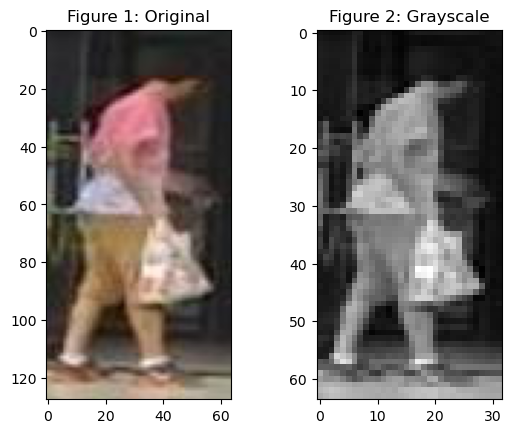

In [5]:
# resize data and convert to grayscale
train_X_small_gray = convert_to_grayscale(resize(train_X, (64, 32)))
print("train_X_small_gray", train_X_small_gray.shape)
# plot_images(train_X_small_gray, train_Y)

# resize data and convert to grayscale
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))

print("gallery_X_small_gray",gallery_X_small_gray.shape)
print("probe_X_small_gray",probe_X_small_gray.shape)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_X[0])
axs[0].set_title("Figure 1: Original")
axs[1].imshow(train_X_small_gray[0], cmap='gray')
axs[1].set_title("Figure 2: Grayscale")
plt.show()




### Vectorising Data

To use the images with non-DL methods, they need to be vectorised. A function is provided for this.

In [6]:
# vectorise some data
train_feat = vectorise(train_X_small_gray)
gallery_feat = vectorise(gallery_X_small_gray)
probe_feat = vectorise(probe_X_small_gray)

print("train_feat", train_feat.shape)
print("gallery_feat", gallery_feat.shape)
print("probe_feat", probe_feat.shape)

#
# at this point, you have data in the shape (gallery_samples, number_of_features) and (probe_samples, number_of_features)
# and you could compare these two sets of features
#
# using colour data alone is a poor feature choice, but nonetheless you could do this.

train_feat (5933, 2048)
gallery_feat (301, 2048)
probe_feat (301, 2048)


## Non- Deep learning method PCA

We have some data, we'll compute our PCA space now and have a look at what we can do.

In [7]:
# Apply PCA transform to train features
from time import process_time

# Measure runtime of entire process
start_time = process_time()

pca = decomposition.PCA()
pca.fit(train_feat)
transformed = pca.transform(train_feat)

# fig = plt.figure(figsize=[16, 8])  # bigger figure size
# for i in range(5):
#     ax = fig.add_subplot(4, 5, i + 1)
#     pc = np.reshape(pca.components_[i,:], (64, 32))        
#     ax.imshow(pc[:,:])

The cumulative sum of PCA explained variance shows the amount of variance explained by each principal component in a decreasing order. This information can be used to determine the optimal number of principal components to use for dimensionality reduction while still preserving a significant amount of information.

In [8]:
# cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
# fig = plt.figure(figsize=[10, 10])
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(cumulative_sum)
# ax.set_title('Cumulative Sum of PCA Explained Variance')
# ax.set_ylabel('Explained Variance')
# ax.set_xlabel('Number of Components')
# cumulative_sum

In [9]:
# top90 = np.where(cumulative_sum > 0.90)[0][0]
# # print('90% in ' + '%d' % (top90+1) + ' components')
# top95 = np.where(cumulative_sum > 0.95)[0][0]
# # print('95% in ' + '%d' % (top95+1) + ' components')
# top99 = np.where(cumulative_sum > 0.99)[0][0]
# # print('99% in ' + '%d' % (top99+1) + ' components')

# fig = plt.figure(figsize=[12, 5])
# ax = fig.add_subplot(1, 5, 1)
# ori = np.reshape(train_feat[0,:] - pca.mean_, (64, 32,1))
# ax.imshow(ori[:,:,0])
# ax.set_title('Original');

# ax = fig.add_subplot(1, 5, 2)
# ninety = np.reshape((np.reshape(transformed[0,0:top90], (1, -1)).dot(pca.components_[0:top90,:])), (64, 32,1))
# ax.imshow(ninety[:,:,0])
# ax.set_title('90% Reconstruction');

# ax = fig.add_subplot(1, 5, 3)
# ninetyfive = np.reshape((np.reshape(transformed[0,0:top95], (1, -1)).dot(pca.components_[0:top95,:])), (64, 32,1))
# ax.imshow(ninetyfive[:,:,0])
# ax.set_title('95% Reconstruction');

# ax = fig.add_subplot(1, 5, 4)
# ninetynine = np.reshape((np.reshape(transformed[0,0:top99], (1, -1)).dot(pca.components_[0:top99,:])), (64, 32,1))
# ax.imshow(ninetynine[:,:,0])
# ax.set_title('99% Reconstruction');

# ax = fig.add_subplot(1, 5, 5)
# hundy = np.reshape((np.reshape(transformed[0,:], (1, -1)).dot(pca.components_[:,:])), (64, 32,1))
# ax.imshow(hundy[:,:,0])
# ax.set_title('FULL Reconstruction');

In [10]:
# we will create a list of IDs, these are the gallery and probe IDs
gallery_ID_Y = np.arange(0, len(gallery_Y), 1)
probe_ID_Y = np.arange(0, len(probe_Y), 1)
pcatrans_gallery_feat = pca.transform(gallery_feat)
pcatrans_probe_feat = pca.transform(probe_feat)
# rank_hist = get_ranked_histogram_l1_distance(pcatrans_gallery_feat, gallery_ID_Y, pcatrans_probe_feat, probe_ID_Y)

# cmc = ranked_hist_to_CMC(rank_hist)

# # plot_cmc(cmc, " - PCA")
# n_values = [1, 5, 10]
# print("PCA")
# for n in n_values:
#     top_n_accuracy = cmc[n-1]
#     print(f'Top-{n} Accuracy: {top_n_accuracy:.2%}')

## Non- Deep learning method LDA

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(train_feat, train_Y)
transformed = lda.transform(train_feat)

# fig = plt.figure(figsize=[16, 8])
# for i in range(5):
#     ax = fig.add_subplot(4, 5, i + 1)
#     pc = np.reshape(lda.coef_[i,:], (64, 32))
#     ax.imshow(pc[:,:])

In [12]:
# cumulative_sum = np.cumsum(lda.explained_variance_ratio_, axis=0)
# # print(lda.explained_variance_ratio_)
# fig = plt.figure(figsize=[10, 10])
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(cumulative_sum)
# ax.set_title('Cumulative Sum of LDA Explained Variance')
# ax.set_ylabel('Explained Variance')
# ax.set_xlabel('Number of Components')
# # cumulative_sum

In [13]:
# we will create a list of IDs, these are the gallery and probe IDs
ldatrans_gallery_feat = lda.transform(gallery_feat)
ldatrans_probe_feat = lda.transform(probe_feat)
# rank_hist = get_ranked_histogram_l1_distance(ldatrans_gallery_feat, gallery_ID_Y, ldatrans_probe_feat, probe_ID_Y)

# cmc = ranked_hist_to_CMC(rank_hist)

# # plot_cmc(cmc, " - LDA")
# n_values = [1, 5, 10]

# print("LDA")
# for n in n_values:
#     top_n_accuracy = cmc[n-1]
#     print(f'Top-{n} Accuracy: {top_n_accuracy:.2%}')

Combination of PCA and LDA
Top-1 Accuracy: 1.00%
Top-5 Accuracy: 1.99%
Top-10 Accuracy: 4.65%
Total runtime: 41.92 seconds


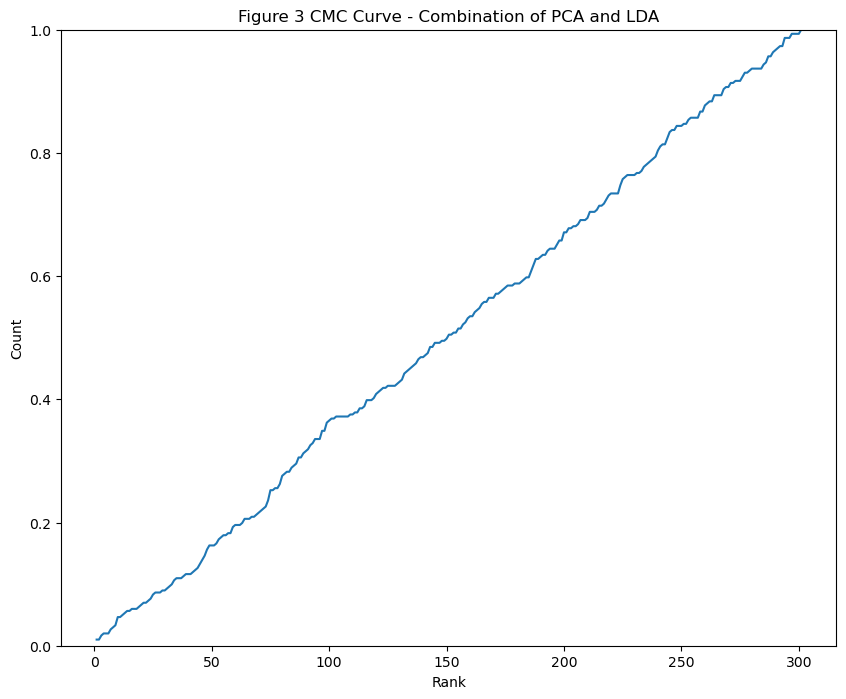

In [14]:

## Combination of PCA and LDA
# we will create a list of IDs, these are the gallery and probe IDs
ldatrans_gallery_feat = lda.transform(pcatrans_gallery_feat)
ldatrans_probe_feat = lda.transform(pcatrans_probe_feat)
rank_hist = get_ranked_histogram_l1_distance(ldatrans_gallery_feat, gallery_ID_Y, ldatrans_probe_feat, probe_ID_Y)

cmc = ranked_hist_to_CMC(rank_hist)

plot_cmc("Figure 3 ",cmc, " - Combination of PCA and LDA")
n_values = [1, 5, 10]

print("Combination of PCA and LDA")
for n in n_values:
    top_n_accuracy = cmc[n-1]
    print(f'Top-{n} Accuracy: {top_n_accuracy:.2%}')
# Measure runtime
end_time = process_time()
runtime = end_time - start_time
print(f"Total runtime: {runtime:.2f} seconds")

# Pair and Triplet Data

## Pair and triplet functions are provided to pull out paired and triplet data for use with Siamese networks.

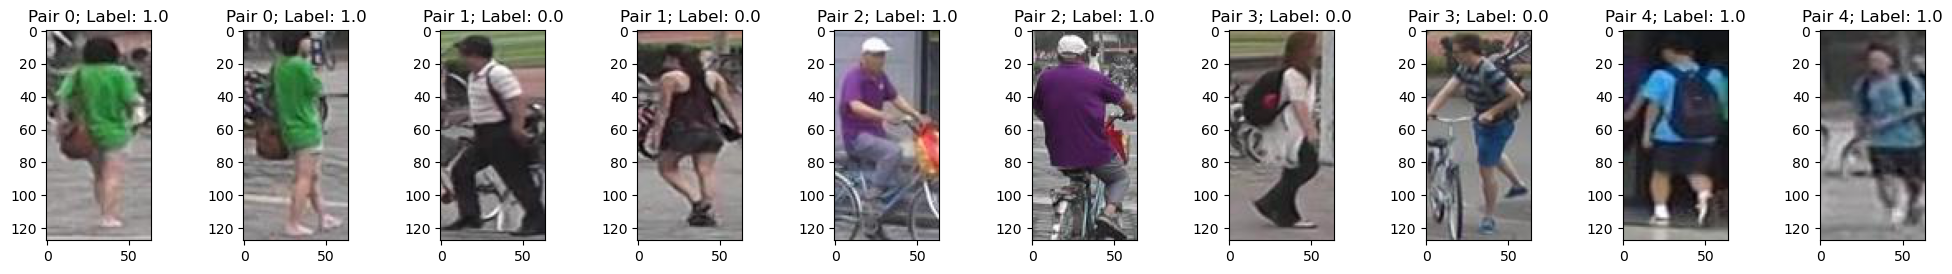

In [15]:
# create a pair generator and display a pair
pair_test = pair_generator(train_X, train_Y, 10)
x, y = next(pair_test)
plot_pairs(x, y)

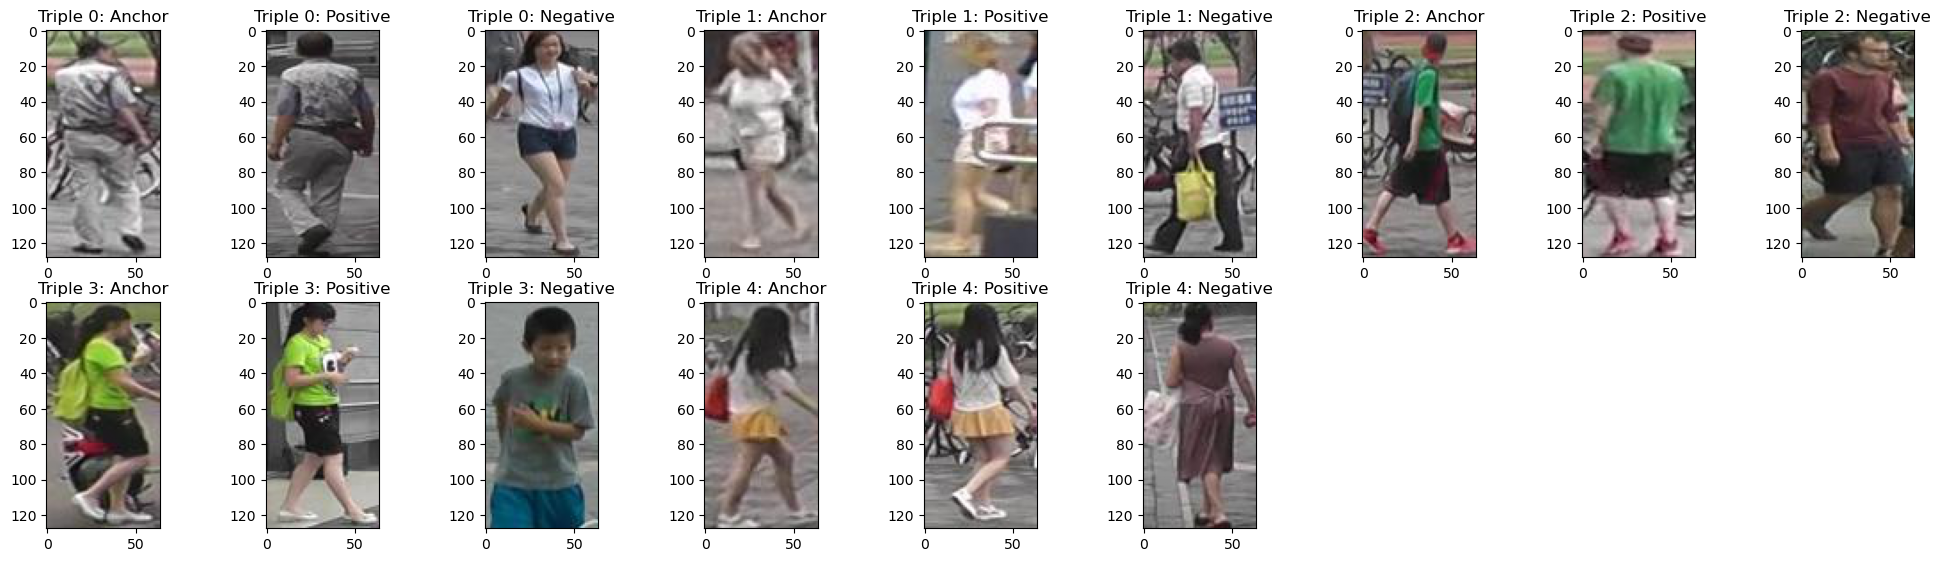

In [16]:
# create a triplet and display a triplet
triplet_test = triplet_generator(train_X, train_Y, 9)
x, _ = next(triplet_test)
plot_triplets(x)

The benefit of using Siamese networks with pair and triplet data is that they allow for more accurate similarity comparisons between pairs or triplets of data points. This is particularly useful in tasks such as image or text similarity, where the goal is to determine how similar two or more pieces of data are to each other. Siamese networks with pair and triplet data can also be used for tasks such as classification and ranking, where the goal is to determine which of a set of possible labels or options is most appropriate for a given input.

The pair_generator function generates a pair of images where the first image in the pair is a random image from the training set, and the second image is either another image from the same class (positive pair) or a different class (negative pair). The corresponding labels for a pair are 1 if they belong to the same class (positive pair) and 0 if they belong to different classes (negative pair).

Similarly, the triplet_generator function generates a triplet of images and their corresponding labels. A triplet consists of an anchor image, a positive image (same class as anchor), and a negative image (different class than anchor). The corresponding label for a triplet is not used during training, and hence None is yielded.

# Deep Learning 
Build and Train the Network

From here, you can build, train and evaluate the network. 

For building and training you will need to:
* Decide on your network structure, is it a pair, or a triplet?
* Build the backbone
* Create two/three inputs, pass those through the backbone, and then into your loss function
* Setup your siamese/triplet network
* Train the network

Once that is done, you can:
* Pass the embeddings through the backbone
* Use a CKNN (or other classifier of your choosing) to train a simple Re-ID model
* Evaluate said model

I would suggest it's worth trying both a Contrastive and Triplet formulation and comparing the two.

In [17]:
# Measure runtime of entire process
start_time = process_time()
from tensorflow import keras
from tensorflow.keras import layers

def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.05)(x)
    x = layers.RandomZoom(0.05)(x)
    x = layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05))(x)
    
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

def euclidean_distance(vects):
    x, y = vects
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [18]:
%pip install tensorflow==2.8.3
%pip install keras==2.8.0
tf.__version__
# '2.8.3'

  Using cached tensorflow-2.8.3-cp310-cp310-manylinux2010_x86_64.whl (498.5 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.8.0-py2.py3-none-any.whl (462 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0
    Uninstalling tensorflow-2.11.0:
   

'2.11.0'

In [19]:
from tensorflow.keras import backend as K

embedding_size = 32
dropout_rate = 0.2

dummy_input = keras.Input((64, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], dropout_rate, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
embedding_layer = layers.Dropout(dropout_rate)(embedding_layer)  # Adding dropout regularization
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
   
input_anchor = keras.Input((64, 32, 1), name='Anchor')
input_positive = keras.Input((64, 32, 1), name='Positive')
input_negative = keras.Input((64, 32, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_918/3667769101.py", line 7, in <module>
    base_network = vgg_net(dummy_input, [8, 16, 32], [256], dropout_rate, 0)
  File "/tmp/ipykernel_918/509785200.py", line 35, in vgg_net
    x = layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05))(x)
  File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 439, in converted_call
    result = converted_f(*effective_args, **kwargs)
TypeError: Exception encountered when calling layer "random_translation" (type RandomTranslation).

in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__get_config() takes 1 positional argument but 3 were 

In [ ]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop())
batch_size = 128
training_gen = triplet_generator(train_X_small_gray, train_Y, batch_size)
triplet_gallery_x = get_triplet_data(gallery_X_small_gray, gallery_Y, 1000)

history = triplet_network.fit(training_gen, steps_per_epoch=60000//batch_size, epochs=20, 
                              validation_data=(triplet_gallery_x, None))

In [ ]:
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist

# Extract triplet loss features from gallery and probe sets
gallery_feat_triplet = base_network.predict(gallery_X_small_gray)
probe_feat_triplet = base_network.predict(probe_X_small_gray)

# Calculate L2-normalized features
gallery_feat_triplet = normalize(gallery_feat_triplet, axis=1)
probe_feat_triplet = normalize(probe_feat_triplet, axis=1)

# Compute pairwise L2 distances between probe and gallery features
distances = cdist(probe_feat_triplet, gallery_feat_triplet, metric='euclidean')

# Rank gallery samples according to distance from each probe
indices = np.argsort(distances, axis=1)
rank_hist = np.zeros(len(gallery_X_small_gray))

for i in range(len(probe_X)):
    probe_id = probe_ID_Y[i]
    probe_rankings = gallery_ID_Y[indices[i]]
    probe_rank = np.where(probe_rankings == probe_id)[0][0]
    rank_hist[probe_rank:] += 1

# Convert rank histogram to CMC curve
cmc = ranked_hist_to_CMC(rank_hist)

# Plot CMC curve
plot_cmc("Figure 4 ",cmc, " - triplet loss-based Siamese network")

# Calculate top-N accuracies and print results
n_values = [1, 5, 10]

print("Triplet Loss")
for n in n_values:
    top_n_accuracy = cmc[n-1]
    print(f'Top-{n} Accuracy: {top_n_accuracy:.2%}')
# Measure runtime
end_time = process_time()
runtime = end_time - start_time
print(f"Total runtime: {runtime:.2f} seconds")


In [ ]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(history.history['loss'], label='Training Loss')
# ax.plot(history.history['val_loss'], label='Validation Loss')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('Loss')
# ax.set_title('Figure 3: Triplet Network - Training and Validation (Gallery) Loss')
# ax.legend()
# plt.show()


In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Get embeddings for training set
# embeddings = base_network.predict(train_X_small_gray)

# # Perform t-SNE dimensionality reduction
# tsne = TSNE(n_components=2, perplexity=30, learning_rate=20)
# embeddings_2d = tsne.fit_transform(embeddings)

# # Plot the embeddings
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_Y)
# plt.colorbar()
# plt.title("t-SNE visualization of embeddings")
# plt.show()


In [ ]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop())
batch_size = 128
training_gen = triplet_generator(train_X_small_gray, train_Y, batch_size)
triplet_probe_x = get_triplet_data(probe_X_small_gray, probe_Y, 1000)

history = triplet_network.fit(training_gen, steps_per_epoch=60000//batch_size, epochs=20, 
                              validation_data=(triplet_probe_x, None))

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(history.history['loss'], label='Training Loss')
# ax.plot(history.history['val_loss'], label='Validation Loss')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('Loss')
# ax.set_title('Training and Validation (Probe) Loss')
# ax.legend()
# plt.show()

In [ ]:
# Contrastive
input_a = keras.Input((64, 32, 1), name='InputA')
input_b = keras.Input((64, 32, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)
distance = layers.Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

siamese_network = keras.Model([input_a, input_b], distance)
keras.utils.plot_model(siamese_network, show_shapes=True)

siamese_network.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
siamese_network.summary()


In [ ]:
batch_size = 128
training_gen = pair_generator(train_X_small_gray , train_Y, batch_size)

siamese_test_x, siamese_test_y = get_siamese_data(gallery_X_small_gray , gallery_Y, 10000)

history = siamese_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=20, validation_data = (siamese_test_x, siamese_test_y))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Figure 4: Contrastive Loss - Training and Validation (Gallery) Loss')
ax.legend()
plt.show()

In [ ]:
siamese_test_x, siamese_test_y = get_siamese_data(probe_X_small_gray , probe_Y, 10000)

history = siamese_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=20, validation_data = (siamese_test_x, siamese_test_y))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation (Probe) Loss')
ax.legend()
plt.show()

In [ ]:
from scipy.spatial.distance import cdist

# Extract embeddings from gallery and probe sets
gallery_embeddings = base_network.predict(gallery_X_small_gray)
probe_embeddings = base_network.predict(probe_X_small_gray)

# Compute pairwise distances between probe and gallery embeddings
distances = cdist(probe_embeddings, gallery_embeddings, metric='euclidean')
similarities = 1.0 / (1.0 + distances)

# Rank gallery pairs according to similarity score from each probe pair
indices = np.argsort(similarities, axis=1)
rank_hist = np.zeros(len(gallery_Y))

for i in range(len(probe_Y)):
    probe_id = probe_Y[i]
    probe_rankings = gallery_Y[indices[i]]
    probe_rank = np.where(probe_rankings == probe_id)[0][0]
    rank_hist[probe_rank:] += 1

# Convert rank histogram to CMC curve
cmc = ranked_hist_to_CMC(rank_hist)

# Plot CMC curve
plot_cmc(cmc, "contrastive loss-based Siamese network")

# Calculate top-N accuracies and print results
n_values = [1, 5, 10]

print("contrastive loss-based Siamese network")
for n in n_values:
    top_n_accuracy = cmc[n-1]
    print(f'Top-{n} Accuracy: {top_n_accuracy:.2%}')
